In [177]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import array
import math
from scipy import stats
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model


In [274]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [198]:
#load your data to train or predict on 
raw_data = pd.read_csv(f"https://s3.amazonaws.com/globefutures/data/CME_CL1.csv", usecols=[7])
df = raw_data

In [286]:
df_z = np.abs(stats.zscore(df))
print(df_z)

[[0.72342736]
 [0.7342664 ]
 [0.7199309 ]
 ...
 [0.470964  ]
 [0.4762087 ]
 [0.47236259]]


In [287]:
threshhold = 5
print(np.where(df_z>threshhold))
df_o = df[(df_z < threshhold).all(axis=1)]

(array([], dtype=int64), array([], dtype=int64))


Raw Data: (9068, 1)
Data with Z-Scores > 5 removed: (9068, 1)


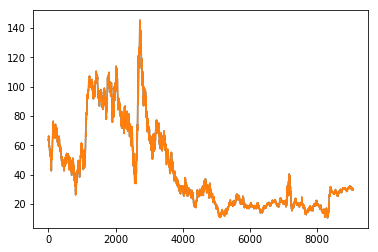

In [288]:
print(f"Raw Data: {df.shape}")
print(f"Data with Z-Scores > {threshhold} removed: {df_o.shape}")
plt.plot(df)
plt.plot(df_o)

In [289]:
dataset = df_o
dataset = dataset.values
dataset = dataset.astype('float32')


In [290]:
#scale the data, makes the model happy
np.random.seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [291]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6075 2993


In [292]:
look_back = 15 # sets how many steps out from the current step model is looking, 3 is two days in our timeseries. The current day and two days out.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [293]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [297]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
 - 9s - loss: 6.4742e-04
Epoch 2/50
 - 7s - loss: 2.6424e-04
Epoch 3/50
 - 6s - loss: 2.3658e-04
Epoch 4/50
 - 7s - loss: 2.0797e-04
Epoch 5/50
 - 8s - loss: 2.0068e-04
Epoch 6/50
 - 7s - loss: 1.9844e-04
Epoch 7/50
 - 7s - loss: 1.7747e-04
Epoch 8/50
 - 7s - loss: 1.7558e-04
Epoch 9/50
 - 7s - loss: 1.7047e-04
Epoch 10/50
 - 7s - loss: 1.6829e-04
Epoch 11/50
 - 7s - loss: 1.6085e-04
Epoch 12/50
 - 7s - loss: 1.6517e-04
Epoch 13/50
 - 7s - loss: 1.6001e-04
Epoch 14/50
 - 7s - loss: 1.5872e-04
Epoch 15/50
 - 7s - loss: 1.5715e-04
Epoch 16/50
 - 7s - loss: 1.5342e-04
Epoch 17/50
 - 8s - loss: 1.5434e-04
Epoch 18/50
 - 7s - loss: 1.5340e-04
Epoch 19/50
 - 7s - loss: 1.4955e-04
Epoch 20/50
 - 7s - loss: 1.4561e-04
Epoch 21/50
 - 7s - loss: 1.4650e-04
Epoch 22/50
 - 8s - loss: 1.4558e-04
Epoch 23/50
 - 7s - loss: 1.4645e-04
Epoch 24/50
 - 7s - loss: 1.4371e-04
Epoch 25/50
 - 7s - loss: 1.4562e-04
Epoch 26/50
 - 7s - loss: 1.4242e-04
Epoch 27/50
 - 7s - loss: 1.3976e-04
Epoch 28/5

In [298]:
model.save('filename.h5') #change file name! lstm_modelCLstep15, lstm_modelCL

In [295]:
model = load_model('lstm_modelCL.h5') #load a model 

Train Score: 1.36 RMSE
Test Score: 0.54 RMSE


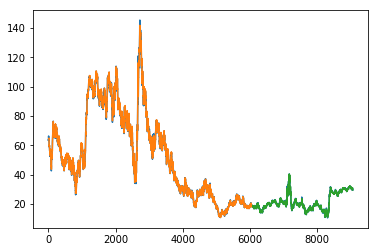

In [299]:
# make predictions
trainPredict = model.predict(trainX, verbose=2)
testPredict = model.predict(testX, verbose=2)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

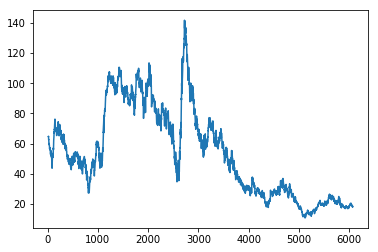

In [318]:
plt.plot(trainPredictPlot)


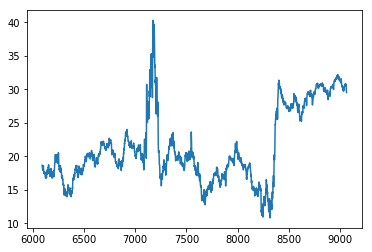

In [319]:
plt.plot(testPredictPlot)


In [438]:
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


Crude Oil Contract - Univariate

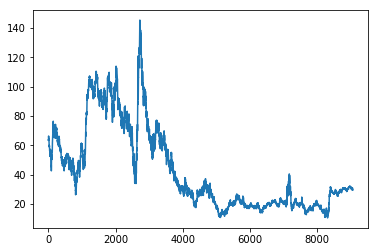